In [13]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import RMSprop

In [14]:
target = pd.read_pickle('target_prices.pkl')

In [15]:
y_scaler_1 = MinMaxScaler()
y_scaler_2 = MinMaxScaler()
y_scaler_3 = MinMaxScaler()

y_scaler_1.fit(np.array(target['1_h']).reshape(-1, 1))
y_scaler_2.fit(target[['1_h', '24_h']])
y_scaler_3.fit(target)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
data = pd.read_pickle('master_dataset_06122019.pkl')

In [17]:
data.columns

Index(['de', 'dk1', 'dk2', 'no2', 'se3', 'se4', 'system', 'CentralProd_dk1',
       'ElectricBoilerCon_dk1', 'ExchangeContinent_dk1',
       'ExchangeGreatBelt_dk1', 'ExchangeNordicCountries_dk1', 'GrossCon_dk1',
       'LocalPowerProd_dk1', 'NetCon_dk1', 'OnshoreWindPower_dk1',
       'SolarPowerProd_dk1', 'CentralProd_dk2', 'ElectricBoilerCon_dk2',
       'ExchangeContinent_dk2', 'ExchangeNordicCountries_dk2', 'GrossCon_dk2',
       'LocalPowerProd_dk2', 'NetCon_dk2', 'OnshoreWindPower_dk2',
       'SolarPowerProd_dk2', 'sun', 'temp', 'wind', 'hour', 'weekday',
       'Offshore_dk1', 'Offshore_dk2', 'pred_+1', 'pred_+24', 'pred_+48',
       'price_bin'],
      dtype='object')

## 1+24+48 pred


In [18]:
model = Sequential()
model.add(LSTM(units=100,
               input_shape=(None, 37,),
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=30,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=20,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(3, activation='relu'))

In [19]:
warmup_steps = 30

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the mean squared error between y_true and y_pred but ignores the warmup-period of the sequence,
    as there is not yet enough data to make serious predictions.
    """
    
    # The shape of both input tensors are 
    # (batch_size, sequence_length, num_y_signals)
    
    # Ignore the warm-up period by taking slices of the tensors
    y_true_slice = y_true[: , warmup_steps: , :]
    y_pred_slice = y_pred[: , warmup_steps: , :]
    
    # The sliced tensors have the shape (batch_size, sequence_length - warmup_length, num_y_signals)
    
    # Calculate the MSE loss for each value pair
    #loss = tf.losses.mean_squared_error(y_true_slice, y_pred_slice)
    #loss = tf.losses.softmax_cross_entropy(y_true_slice, y_pred_slice)
    loss = tf.keras.losses.MSLE(y_true_slice, y_pred_slice)
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean

In [20]:
x_sc = MinMaxScaler()
data_scaled = x_sc.fit_transform(data)

In [21]:
model.load_weights('1+24+48+pred.keras')

In [22]:
preds = model.predict(np.expand_dims(data_scaled, axis=0))

In [23]:
preds_rescaled = y_scaler_3.inverse_transform(preds[0, :, :])
p_48_pred = y_scaler_3.inverse_transform(preds[0, :, :])

In [24]:
len(target) - preds_rescaled[:-48,:].shape[0]

48

In [25]:
error = [target['48_h'][48+i] - preds_rescaled[i,2] for i in range(preds_rescaled[:-48,:].shape[0])]

In [26]:
error_abs = [np.abs(error[i]) for i in range(len(error))]

In [27]:
print(np.array(error_abs).mean())
print(np.array(error_abs).std())

58.81686245573488
70.03989582795333


In [33]:
error_48 = pd.DataFrame(error_abs, index=target.index[48:])

In [40]:
import datetime
print("is std:", error_48[0][error_48.index.date < datetime.date(2017, 1, 1)].std())
print("oos std:", error_48[0][error_48.index.date >= datetime.date(2017, 1, 1)].std())

is std: 69.08827527810499
oos std: 71.81780928634123


In [42]:
error_df = pd.DataFrame(error_abs, index=target.index[48:])

In [43]:
error_df = pd.concat([target['48_h'][48:], error_df], join='inner', axis=1)

In [44]:
error_df = pd.concat([error_df, data['price_bin']], axis=1, join='inner')

In [46]:
error_dict = {}
for i in range(100):
    error_dict[i] = [error_df[error_df.price_bin == i][0].mean(),
                     error_df[error_df.price_bin == i][0].median()]

In [47]:
e_df = pd.DataFrame.from_dict(error_dict, orient='index', columns=['mean', 'median'])

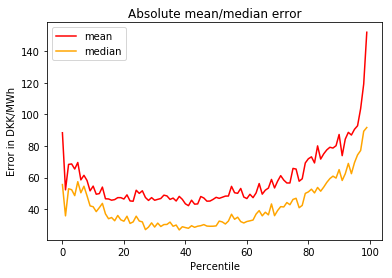

In [48]:
plt.plot(e_df['mean'], label='mean', color='red')
plt.plot(e_df['median'], label='median', color='orange')
plt.title('Absolute mean/median error')
plt.xlabel('Percentile')
plt.ylabel('Error in DKK/MWh')
plt.legend()
plt.show()

## 1+pred

In [49]:
model = Sequential()
model.add(LSTM(units=100,
               input_shape=(None, 35,),
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=30,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=20,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(1, activation='relu'))

In [50]:
x_sc = MinMaxScaler()
data_scaled = x_sc.fit_transform(data.drop(['pred_+48', 'pred_+24'], axis=1))

In [51]:
model.load_weights('1+pred.keras')

In [52]:
preds = model.predict(np.expand_dims(data_scaled, axis=0))

In [53]:
preds_rescaled = y_scaler_1.inverse_transform(preds[0, :, :])
p_1_pred = y_scaler_1.inverse_transform(preds[0, :, :])

In [54]:
error = [target['1_h'][1+i] - preds_rescaled[i,0] for i in range(preds_rescaled[:-1,:].shape[0])]

In [55]:
error_abs = [np.abs(error[i]) for i in range(len(error))]

In [56]:
print(np.array(error_abs).mean())
print(np.array(error_abs).std())

55.616973206111005
48.917001487107626


In [57]:
error_1 = pd.DataFrame(error_abs, index=target.index[1:])

In [58]:
print("is std:", error_1[0][error_1.index.date < datetime.date(2017, 1, 1)].std())
print("oos std:", error_1[0][error_1.index.date >= datetime.date(2017, 1, 1)].std())

is std: 50.06214599589473
oos std: 46.32039550638476


In [ ]:
error_df = pd.DataFrame(error_abs, index=target.index[1:])

In [ ]:
error_df = pd.concat([target['1_h'][1:], error_df], join='inner', axis=1)

In [ ]:
error_df = pd.concat([error_df, data['price_bin']], axis=1, join='inner')

In [ ]:
error_dict = {}
for i in range(100):
    error_dict[i] = [error_df[error_df.price_bin == i][0].mean(),
                     error_df[error_df.price_bin == i][0].median()]

In [ ]:
e_df = pd.DataFrame.from_dict(error_dict, orient='index', columns=['mean', 'median'])

In [ ]:
plt.plot(e_df['mean'], label='mean', color='red')
plt.plot(e_df['median'], label='median', color='orange')
plt.title('Absolute mean/median error')
plt.xlabel('Percentile')
plt.ylabel('Error in DKK/MWh')
plt.legend()
plt.show()

## 1 no pred

In [59]:
model = Sequential()
model.add(LSTM(units=100,
               input_shape=(None, 34,),
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=30,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=20,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(1, activation='relu'))

In [60]:
x_sc = MinMaxScaler()
data_scaled = x_sc.fit_transform(data.drop(['pred_+48', 'pred_+24', 'pred_+1'], axis=1))

In [61]:
model.load_weights('1.keras')

In [62]:
preds = model.predict(np.expand_dims(data_scaled, axis=0))

In [63]:
preds_rescaled = y_scaler_1.inverse_transform(preds[0, :, :])
p_1_no = y_scaler_1.inverse_transform(preds[0, :, :])

In [64]:
error = [target['1_h'][1+i] - preds_rescaled[i,0] for i in range(preds_rescaled[:-1,:].shape[0])]

In [65]:
error_abs = [np.abs(error[i]) for i in range(len(error))]

In [66]:
print(np.array(error_abs).mean())
print(np.array(error_abs).std())

72.43701924027638
52.42818153195882


In [67]:
error_1_no = pd.DataFrame(error_abs, index=target.index[1:])

In [68]:
print("is std:", error_1_no[0][error_1_no.index.date < datetime.date(2017, 1, 1)].std())
print("oos std:", error_1_no[0][error_1_no.index.date >= datetime.date(2017, 1, 1)].std())

is std: 53.5219521633673
oos std: 50.124606602393456


In [ ]:
error_df = pd.DataFrame(error_abs, index=target.index[1:])

In [ ]:
error_df = pd.concat([target['1_h'][1:], error_df], join='inner', axis=1)

In [ ]:
error_df = pd.concat([error_df, data['price_bin']], axis=1, join='inner')

In [ ]:
error_dict = {}
for i in range(100):
    error_dict[i] = [error_df[error_df.price_bin == i][0].mean(),
                     error_df[error_df.price_bin == i][0].median()]

In [ ]:
e_df = pd.DataFrame.from_dict(error_dict, orient='index', columns=['mean', 'median'])

In [ ]:
plt.plot(e_df['mean'], label='mean', color='red')
plt.plot(e_df['median'], label='median', color='orange')
plt.title('Absolute mean/median error')
plt.xlabel('Percentile')
plt.ylabel('Error in DKK/MWh')
plt.legend()
plt.show()

## 1+24+48 no pred

In [69]:
model = Sequential()
model.add(LSTM(units=100,
               input_shape=(None, 34,),
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=30,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=20,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(3, activation='relu'))

In [70]:
x_sc = MinMaxScaler()
data_scaled = x_sc.fit_transform(data.drop(['pred_+48', 'pred_+24', 'pred_+1'], axis=1))

In [71]:
model.load_weights('1+24+48.keras')

In [72]:
preds = model.predict(np.expand_dims(data_scaled, axis=0))

In [73]:
preds_rescaled = y_scaler_3.inverse_transform(preds[0, :, :])
p_48_no = y_scaler_3.inverse_transform(preds[0, :, :])

In [74]:
error = [target['48_h'][48+i] - preds_rescaled[i,2] for i in range(preds_rescaled[:-48,:].shape[0])]

In [75]:
error_abs = [np.abs(error[i]) for i in range(len(error))]

In [76]:
error_48_no = pd.DataFrame(error_abs, index=target.index[48:])

In [77]:
print("is std:", error_48_no[0][error_48_no.index.date < datetime.date(2017, 1, 1)].std())
print("oos std:", error_48_no[0][error_48_no.index.date >= datetime.date(2017, 1, 1)].std())

is std: 68.52358777976387
oos std: 72.09528261760377


In [ ]:
error_df = pd.DataFrame(error_abs, index=target.index[48:])

In [ ]:
error_df = pd.concat([target['48_h'][48:], error_df], join='inner', axis=1)

In [ ]:
error_df = pd.concat([error_df, data['price_bin']], axis=1, join='inner')

In [ ]:
error_dict = {}
for i in range(100):
    error_dict[i] = [error_df[error_df.price_bin == i][0].mean(),
                     error_df[error_df.price_bin == i][0].median()]

In [ ]:
e_df = pd.DataFrame.from_dict(error_dict, orient='index', columns=['mean', 'median'])

In [ ]:
plt.plot(e_df['mean'], label='mean', color='red')
plt.plot(e_df['median'], label='median', color='orange')
plt.title('Absolute mean/median error')
plt.xlabel('Percentile')
plt.ylabel('Error in DKK/MWh')
plt.legend()
plt.show()

In [ ]:
print(np.array(error_abs).mean())

## 1+24 no pred

In [78]:
model = Sequential()
model.add(LSTM(units=100,
               input_shape=(None, 34,),
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=30,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=20,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(2, activation='relu'))

In [79]:
x_sc = MinMaxScaler()
data_scaled = x_sc.fit_transform(data.drop(['pred_+48', 'pred_+24', 'pred_+1'], axis=1))

In [80]:
model.load_weights('1+24.keras')

In [81]:
preds = model.predict(np.expand_dims(data_scaled, axis=0))

In [82]:
preds_rescaled = y_scaler_2.inverse_transform(preds[0, :, :])
p_24_no = y_scaler_2.inverse_transform(preds[0, :, :])

In [83]:
error = [target['24_h'][24+i] - preds_rescaled[i,1] for i in range(preds_rescaled[:-24,:].shape[0])]

In [84]:
error_abs = [np.abs(error[i]) for i in range(len(error))]

In [85]:
error_24_no = pd.DataFrame(error_abs, index=target.index[24:])

In [86]:
print("is std:", error_24_no[0][error_24_no.index.date < datetime.date(2017, 1, 1)].std())
print("oos std:", error_24_no[0][error_24_no.index.date >= datetime.date(2017, 1, 1)].std())

is std: 65.49528819836252
oos std: 70.52575131330177


In [ ]:
error_df = pd.DataFrame(error_abs, index=target.index[24:])

In [ ]:
error_df = pd.concat([target['24_h'][24:], error_df], join='inner', axis=1)

In [ ]:
error_df = pd.concat([error_df, data['price_bin']], axis=1, join='inner')

In [ ]:
error_dict = {}
for i in range(100):
    error_dict[i] = [error_df[error_df.price_bin == i][0].mean(),
                     error_df[error_df.price_bin == i][0].median()]

In [ ]:
e_df = pd.DataFrame.from_dict(error_dict, orient='index', columns=['mean', 'median'])

In [ ]:
plt.plot(e_df['mean'], label='mean', color='red')
plt.plot(e_df['median'], label='median', color='orange')
plt.title('Absolute mean/median error')
plt.xlabel('Percentile')
plt.ylabel('Error in DKK/MWh')
plt.legend()
plt.show()

In [ ]:
print(np.array(error_abs).mean())

## 1+24 pred

In [87]:
model = Sequential()
model.add(LSTM(units=100,
               input_shape=(None, 36,),
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=30,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=20,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(2, activation='relu'))

In [88]:
x_sc = MinMaxScaler()
data_scaled = x_sc.fit_transform(data.drop(['pred_+48'], axis=1))

In [89]:
model.load_weights('1+24+pred.keras')

In [90]:
preds = model.predict(np.expand_dims(data_scaled, axis=0))

In [91]:
preds_rescaled = y_scaler_2.inverse_transform(preds[0, :, :])
p_24_pred = y_scaler_2.inverse_transform(preds[0, :, :])

In [92]:
error = [target['24_h'][24+i] - preds_rescaled[i,1] for i in range(preds_rescaled[:-24,:].shape[0])]

In [93]:
error_abs = [np.abs(error[i]) for i in range(len(error))]

In [94]:
error_24 = pd.DataFrame(error_abs, index=target.index[24:])

In [95]:
print("is std:", error_24[0][error_24.index.date < datetime.date(2017, 1, 1)].std())
print("oos std:", error_24[0][error_24.index.date >= datetime.date(2017, 1, 1)].std())

is std: 66.61656976934454
oos std: 70.93154127389825


In [ ]:
error_df = pd.DataFrame(error_abs, index=target.index[24:])

In [ ]:
error_df = pd.concat([target['24_h'][24:], error_df], join='inner', axis=1)

In [ ]:
error_df = pd.concat([error_df, data['price_bin']], axis=1, join='inner')

In [ ]:
error_dict = {}
for i in range(100):
    error_dict[i] = [error_df[error_df.price_bin == i][0].mean(),
                     error_df[error_df.price_bin == i][0].median()]

In [ ]:
e_df = pd.DataFrame.from_dict(error_dict, orient='index', columns=['mean', 'median'])

In [ ]:
plt.plot(e_df['mean'], label='mean', color='red')
plt.plot(e_df['median'], label='median', color='orange')
plt.title('Absolute mean/median error')
plt.xlabel('Percentile')
plt.ylabel('Error in DKK/MWh')
plt.legend()
plt.show()

In [ ]:
print(np.array(error_abs).mean())

In [ ]:
prediction_dict = {
    '1_no' : p_1_no,
    '1_pred': p_1_pred,
    '24_no': p_24_no,
    '24_pred': p_24_pred,
    '48_no': p_48_no,
    '48_pred': p_48_pred
}

In [ ]:
filehandler = open('./prediction.pkl', 'wb')
pickle.dump(prediction_dict, filehandler)